# numba acceleration

timing the Numba compiler's acceleration effect on NumPy trigonometry and array broadcasting functions

both Numba functions are called once for just-in-time compilation<br>
they are compiled in nophython mode witch generates code that does not access the Python C API<br>
(this compilation mode produces the highest performance code)


In [1]:
from numba import jit
import numpy as np
import timeit
import matplotlib.pyplot as plt

In [2]:
def default_trig(a):
    trace = 0.0
    for i in range(a.shape[0]):
        trace += np.tanh(a[i, i])
    return a + trace

@jit(nopython=True)
def numba_trig(a):
    trace = 0.0
    for i in range(a.shape[0]):
        trace += np.tanh(a[i, i])
    return a + trace

In [3]:
x = np.arange(100).reshape(10, 10)
numba_trig(x);

---

In [4]:
def default_convolution(kernel, image):
    kernel_height, kernel_width = kernel.shape
    image_height, image_width = image.shape
    
    output_height = image_height - kernel_height + 1
    output_width = image_width - kernel_width + 1
    output = np.zeros((output_height, output_width))
    
    for i in range(output_height):
        for j in range(output_width):
            output[i, j] = np.sum(kernel * image[i:i+kernel_height, j:j+kernel_width])
    
    return output

@jit(nopython=True)
def numba_convolution(kernel, image):
    kernel_height, kernel_width = kernel.shape
    image_height, image_width = image.shape
    
    output_height = image_height - kernel_height + 1
    output_width = image_width - kernel_width + 1
    output = np.zeros((output_height, output_width))
    
    for i in range(output_height):
        for j in range(output_width):
            output[i, j] = np.sum(kernel * image[i:i+kernel_height, j:j+kernel_width])
    
    return output

In [5]:
kernel = np.array([[1, 0, -1],
                   [1, 0, -1],
                   [1, 0, -1]])
image = np.random.randint(0, 255, size=(100, 100))
numba_convolution(kernel, image);

## benchmarks

In [6]:
def time(default_func, numba_func, repeat=1000, number=1000):
    def_timer = timeit.Timer(default_func, globals=globals())
    numba_timer = timeit.Timer(numba_func, globals=globals())
    
    def_times= def_timer.repeat(repeat=repeat, number=number)
    numba_times = numba_timer.repeat(repeat=repeat, number=number)
    
    speedups = [d / n if n > 0 else float('inf') for d, n in zip(def_times, numba_times)]
    avg_speedup = np.mean(speedups)

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, repeat+1), speedups, color='b', label="speedup (default / Numba)")
    plt.axhline(y=avg_speedup, color='red', linestyle='--', label=f"average speedup ({avg_speedup:.2f}x)")
    plt.ylim(0, max(speedups) * 1.1)
    plt.xlabel("trial")
    plt.ylabel("speedup")
    plt.title("speed increase of Numba-optimized function")
    plt.legend()
    plt.grid(True)
    plt.show()

#### 1 - trig function:

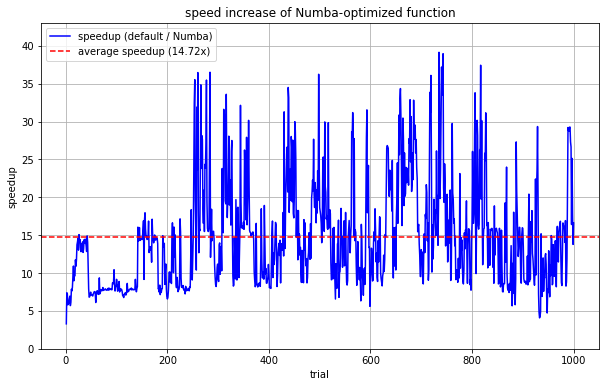

In [7]:
time('default_trig(x)', 'numba_trig(x)')

#### 2 - convolution function:

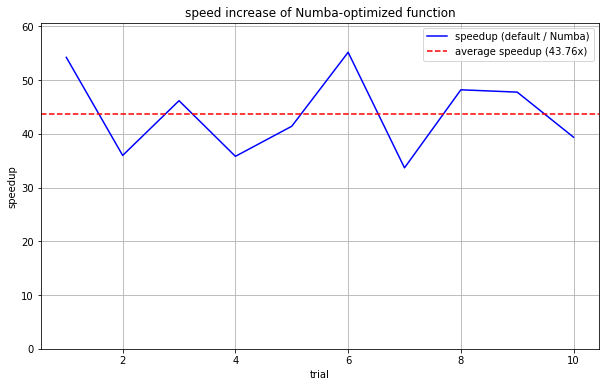

In [8]:
time('default_convolution(kernel, image)', 'numba_convolution(kernel, image)', repeat=10, number=100)